In [1]:
import numpy as np
from scipy.fft import fft
from sklearn.decomposition import PCA
import pywt
import pandas as pd

# 1. Loading/Preprocessing Data

In [2]:
# Initialize an empty list to store the signals
signals_cntrl = []

# Load each signal data file and append it to the signals list
for i in range(1, 11):
    if i < 10:
        file_path = f"Dataset-6_WorkingMemory/ctrl0{i}.npy"
    else: 
        file_path = f"Dataset-6_WorkingMemory/ctrl{i}.npy"
    signal = np.load(file_path)
    signals_cntrl.append(signal)

# Initialize an empty list to store the signals
signals_pts = []

# Load each signal data file and append it to the signals list
for i in range(1, 11):
    if i < 10:
        file_path = f"Dataset-6_WorkingMemory/pfc0{i}.npy"
    else: 
        file_path = f"Dataset-6_WorkingMemory/pfc{i}.npy"
    signal = np.load(file_path)
    signals_pts.append(signal)

In [3]:
# Determine the maximum length among all signals
max_length_cntrl = max(signal.shape[2] for signal in signals_cntrl)
max_length_pts = max(signal.shape[2] for signal in signals_pts)
max_length = max(max_length_cntrl, max_length_pts)
print(max_length)

231


In [4]:
# Pad or truncate signals to the maximum length
padded_signals_cntrl = []
for signal in signals_cntrl:
    if signal.shape[0] < max_length:
        # If signal is shorter than max_length, pad it with zeros along the first dimension
        padded_signal_cntrl = np.pad(signal, ((0, max_length - signal.shape[0]), (0, 0), (0, 0)), mode='constant')
    elif signal.shape[0] > max_length:
        # If signal is longer than max_length, truncate it along the first dimension
        padded_signal_cntrl = signal[:max_length]
    else:
        padded_signal_cntrl = signal  # No need for padding or truncating
    padded_signals_cntrl.append(padded_signal_cntrl)

# Convert the list of padded signals into a NumPy array
padded_signals_array_cntrl = np.array(padded_signals_cntrl)

print(padded_signals_array_cntrl.shape)

(10, 231, 64, 231)


In [5]:
# Pad or truncate signals to the maximum length
padded_signals_pts = []
for signal in signals_pts:
    if signal.shape[0] < max_length:
        # If signal is shorter than max_length, pad it with zeros along the first dimension
        padded_signal_pts = np.pad(signal, ((0, max_length - signal.shape[0]), (0, 0), (0, 0)), mode='constant')
    elif signal.shape[0] > max_length:
        # If signal is longer than max_length, truncate it along the first dimension
        padded_signal_pts = signal[:max_length]
    else:
        padded_signal_pts = signal  # No need for padding or truncating
    padded_signals_pts.append(padded_signal_pts)

# Convert the list of padded signals into a NumPy array
padded_signals_array_pts = np.array(padded_signals_pts)

### displaying time teplresentation of data 

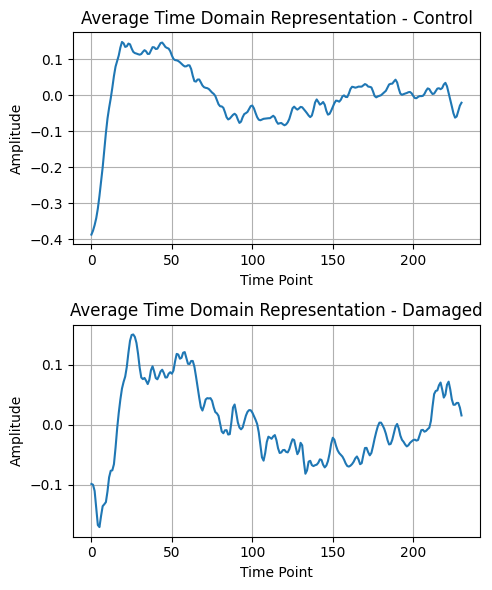

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average signal across all trials, channels, and patients for each time point for each condition
average_signal_control = np.mean(padded_signals_array_cntrl, axis=(0, 1, 2))
average_signal_pts = np.mean(padded_signals_array_pts, axis=(0, 1, 2))

# Plot the time domain representation for each condition in separate subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 6))

# Plot for control condition
axs[0].plot(average_signal_control)
axs[0].set_title('Average Time Domain Representation - Control')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Plot for experimental condition
axs[1].plot(average_signal_pts)
axs[1].set_title('Average Time Domain Representation - Damaged')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

plt.tight_layout()
plt.show()

### displaying frequency distribution of raw data per time point

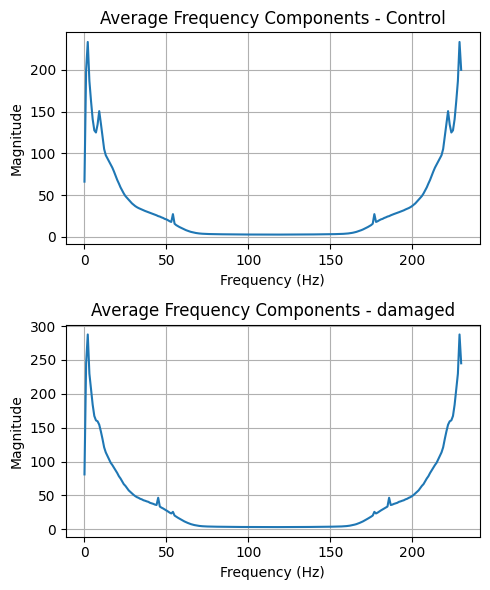

In [ ]:

#  `data` is input array of shape (20, 231, 64, 231)
flattened_data_cntrl = padded_signals_array_cntrl.reshape(-1, 64, 231)  # New shape will be (4620, 64, 231)
flattened_data_pts = padded_signals_array_pts.reshape(-1, 64, 231)
# Perform FFT on the time dimension (axis=-1)
frequency_data_cntrl = np.fft.fft(flattened_data_cntrl, axis=-1)
frequency_data_pts = np.fft.fft(flattened_data_pts, axis=-1)

# Take the magnitude (or power) of the FFT result to get the frequency components
frequency_magnitude_cntrl  = np.abs(frequency_data_cntrl )
frequency_magnitude_pts  = np.abs(frequency_data_pts )

# Calculate the average frequency magnitude across all channels
average_over_all_channels_cntrl = np.mean(frequency_magnitude_cntrl, axis=(0, 1))
average_over_all_channels_pts = np.mean(frequency_magnitude_pts, axis=(0, 1))

# Plot the average frequency magnitude for both conditions in subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 6))

# Plot for control condition
axs[0].plot(average_over_all_channels_cntrl)
axs[0].set_title('Average Frequency Components - Control')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].grid(True)

# Plot for experimental condition
axs[1].plot(average_over_all_channels_pts)
axs[1].set_title('Average Frequency Components - damaged')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True)

plt.tight_layout()
plt.show()

According to this frequency representation, our EEG signal includes artifactes resulted from eye movements with very low frequencies and  muscle movements with very large frequencies. However, working memory activity frequency band is expected to be at range 8-100 HZ. For this reason, we use badpass filtering later on in our project to remove such artifacts.

### Preparing labels and separating the data

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

concatenated_data = np.concatenate((padded_signals_array_cntrl, padded_signals_array_pts), axis = 0)
print(concatenated_data.shape)

# Create a column indicating labels filled with zeros for the first half of the data(control) and ones for the second (pts)
half_length = concatenated_data.shape[0] // 2
labels = np.concatenate((np.zeros((half_length, 1)), np.ones((half_length, 1))), axis=0).flatten()

# Split the combined data into training and remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(concatenated_data, labels, test_size=0.2, random_state=42)

# Further split the remaining data into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


(20, 231, 64, 231)


In [7]:
# Print the original shapes
print("Original shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}")

# Reshape the data to 2D
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Standardize data
scaler = StandardScaler()

# Fit the scaler on the reshaped training data and transform it
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)

# Transform the test and validation data using the same scaler
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

# Reshape the scaled data back to 4D
X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

# Print the final shapes to confirm
print("Reshaped back to 4D:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"X_val_scaled: {X_val_scaled.shape}")


Original shapes:
X_train: (16, 231, 64, 231)
X_test: (2, 231, 64, 231)
X_val: (2, 231, 64, 231)
Reshaped back to 4D:
X_train_scaled: (16, 231, 64, 231)
X_test_scaled: (2, 231, 64, 231)
X_val_scaled: (2, 231, 64, 231)


# 2.Feature Extraction

In [8]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply a Butterworth band-pass filter to the data.
    
    Args:
    - data: 1D numpy array with data to be filtered
    - lowcut: Lower cutoff frequency of the band-pass filter (in Hz)
    - highcut: Upper cutoff frequency of the band-pass filter (in Hz)
    - fs: Sampling frequency of the data (in Hz)
    - order: Order of the Butterworth filter
    
    Returns:
    - filtered_data: Filtered data
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

In [9]:
def apply_fourier_transform_with_bandpass(X, fs):
    """
    Apply Fourier transformation across the time dimension for each channel in EEG data
    after applying a band-pass filter to retain alpha, beta, and gamma frequencies.
    
    Args:
    - pca_transformed_all_data: 4D numpy array with shape (num_data, num_trials, num_channels, num_time_points)
    - fs: Sampling frequency of the data (in Hz)
    
    Returns:
    - freq_domain_data: Frequency domain representation of the EEG data after band-pass filtering
    """
    num_data, num_trials, num_channels, num_time_points = X.shape
    freq_domain_data = np.zeros((num_data, num_trials, num_channels, num_time_points), dtype=np.float64)
    
    for data in range(num_data):
        for trial in range(num_trials):
            for channel in range(num_channels):
                # Apply band-pass filter to retain alpha, beta, and gamma frequencies
                filtered_data = butter_bandpass_filter(X[data, trial, channel, :], 8, 100, fs)
            
                # Apply Fourier transform across time dimension
                freq_coefs = fft(filtered_data)
                
                # Calculate the square of the absolute value of the frequency coefficients
                freq_domain_data[data, trial, channel, :] = np.abs(freq_coefs) ** 2
    
    return freq_domain_data

In [10]:
def apply_pca_to_X(X_train, n_components, pca_dim='channels'):
    """
    Apply PCA to EEG data sets along a specified dimension.

    Args:
    - X_train: EEG data array with shape (num_data, num_trials, num_channels, num_time_points)
    - n_components: Number of principal components to retain
    - pca_dim: Dimension along which to apply PCA ('channels' or 'time_points')

    Returns:
    - pca_transformed_X_train: PCA-transformed data array
    """
    num_data, num_trials, num_channels, num_time_points = X_train.shape
    
    if pca_dim == 'channels':
        pca_transformed_X_train = np.zeros((num_data, num_trials, n_components, num_time_points))
        
        for i, data in enumerate(X_train):
            for time_point in range(num_time_points):
                pca = PCA(n_components=n_components)
                pca.fit(data[:, :, time_point])
                pca_components = pca.transform(data[:, :, time_point])
                pca_transformed_X_train[i, :, :, time_point] = pca_components[:, :n_components]
                variance_explained = pca.explained_variance_ratio_
                
    elif pca_dim == 'time_points':
        pca_transformed_X_train = np.zeros((num_data, num_trials, num_channels, n_components))
        
        for i, data in enumerate(X_train):
            for channel in range(num_channels):
                pca = PCA(n_components=n_components)
                pca.fit(data[:, channel, :])
                pca_components = pca.transform(data[:, channel, :])
                pca_transformed_X_train[i, :, channel, :] = pca_components[:, :n_components]
                variance_explained = pca.explained_variance_ratio_
                
    else:
        raise ValueError("Invalid pca_dim value. Use 'channels' or 'time_points'.")
    
    return pca_transformed_X_train, variance_explained


In [11]:
from scipy.signal import morlet

def apply_morlet_transform(X, wavelet_freq):
    """
    Apply Morlet wavelet transform to EEG data.
    
    Args:
    - pca_transformed_all_data: 4D numpy array with shape (num_data, num_trials, num_channels, num_time_points)
    - wavelet_freq: Frequency of the Morlet wavelet (angular frequency in radians per sample)
    
    Returns:
    - morlet_coeffs: Morlet wavelet coefficients after applying Morlet wavelet transform
    """
    num_data, num_trials, num_channels, num_time_points = X.shape
    morlet_coeffs = np.zeros((num_data, num_trials, num_channels, num_time_points), dtype=np.complex128)

    for d in range(num_data):
        for trial in range(num_trials):
            for channel in range(num_channels):
                # Apply Morlet wavelet transform
                wavelet = morlet(num_time_points, w=wavelet_freq)
                morlet_coeffs[d, trial, channel, :] = np.convolve(X[d, trial, channel, :], wavelet, mode='same')
     # Convert complex coefficients to magnitudes
    magnitudes = np.abs(morlet_coeffs)
    return magnitudes

In [12]:
# Choose optimal number for PCA

# For channel PCA
pca_channels, explained_variance_channels = apply_pca_to_X(X_train_scaled, n_components=10, pca_dim='channels')
print("Explained variance ratio (channels PCA):", explained_variance_channels)

# For time points PCA
pca_time_points, explained_variance_timepoints = apply_pca_to_X(X_train_scaled, n_components=10, pca_dim='time_points')
print("Explained variance ratio (time points PCA):", explained_variance_timepoints)

In [13]:
# Cumulative explained variance
cumulative_explained_variance_channels = np.cumsum(explained_variance_channels)
cumulative_explained_variance_timepoints = np.cumsum(explained_variance_timepoints)

In [14]:
# Plot explained variance ratio for channels PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_channels) + 1), explained_variance_channels, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (Channels PCA)')

# Plot cumulative explained variance for channels PCA
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance_channels) + 1), cumulative_explained_variance_channels, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance (Channels PCA)')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

# Plot explained variance ratio for time points PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_timepoints) + 1), explained_variance_timepoints, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (Time Points PCA)')

# Plot cumulative explained variance for time points PCA
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance_timepoints) + 1), cumulative_explained_variance_timepoints, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance (Time Points PCA)')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

Conclusion:

Channels PCA:
The cumulative explained variance ratio reaches approximately 73.09% with ten components.
The curve appears to plateau after the first few components, suggesting diminishing returns in terms of variance explained by adding more components.
Given that 73.09% of the variance is explained by ten components, this seems like a reasonable choice. 

Time Points PCA:
The cumulative explained variance ratio reaches approximately 57.48% with ten components.
Similar to the Channels PCA, the curve starts to level off after the first few components.
In many cases, aiming for a cumulative explained variance ratio between 70% and 90% is considered a balanced approach. So we may want to increase out number of components.

### Plotting

lets see how time domain and frequency representation of our data differs after bandpass filtering:

In [ ]:
freq_domain_control=apply_fourier_transform_with_bandpass(padded_signals_array_cntrl, fs=256)
freq_domain_pts=apply_fourier_transform_with_bandpass(padded_signals_array_pts, fs=256)
inverse_transformed_control = np.fft.ifft(freq_domain_control, axis=-1) #to convert back to time domain 
inverse_transformed_pts = np.fft.ifft(freq_domain_pts, axis=-1) #to convert back to time domain 


In [ ]:
freq_domain_pts.shape
inverse_transformed_pts.shape

(10, 231, 64, 231)

C:\Users\Bazghandi\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Bazghandi\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


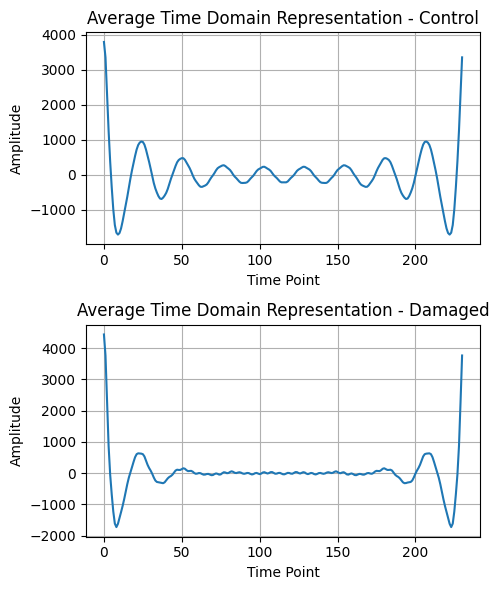

In [ ]:
# Calculate the average signal across all trials, channels, and patients for each time point for each condition
average_signal_control = np.mean(inverse_transformed_control, axis=(0, 1, 2))
average_signal_pts = np.mean(inverse_transformed_pts, axis=(0, 1, 2))

# Plot the time domain representation for each condition in separate subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 6))

# Plot for control condition
axs[0].plot(average_signal_control)
axs[0].set_title('Average Time Domain Representation - Control')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Plot for experimental condition
axs[1].plot(average_signal_pts)
axs[1].set_title('Average Time Domain Representation - Damaged')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

plt.tight_layout()
plt.show()

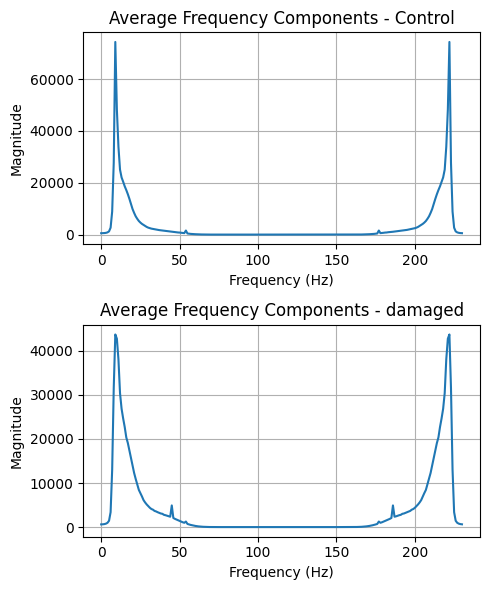

In [ ]:
freq_domain_control_for_plot= np.mean(freq_domain_control, axis=(0, 1, 2))
freq_domain_pts_for_plot= np.mean(freq_domain_pts, axis=(0, 1, 2))

# Take the magnitude (or power) of the FFT result to get the frequency components
frequency_magnitude_cntrl  = np.abs(freq_domain_control_for_plot)
frequency_magnitude_pts  = np.abs(freq_domain_pts_for_plot )



# Plot the average frequency magnitude for both conditions in subplots
fig, axs = plt.subplots(2, 1, figsize=(5, 6))

# Plot for control condition
axs[0].plot(frequency_magnitude_cntrl)
axs[0].set_title('Average Frequency Components - Control')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].grid(True)

# Plot for experimental condition
axs[1].plot(frequency_magnitude_pts)
axs[1].set_title('Average Frequency Components - damaged')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True)

plt.tight_layout()
plt.show()

lets find events for both conditions

#### events for control condition

Statistical Threshold: 11165.910276015482
Percentile-Based Threshold: 1364.2834705078703


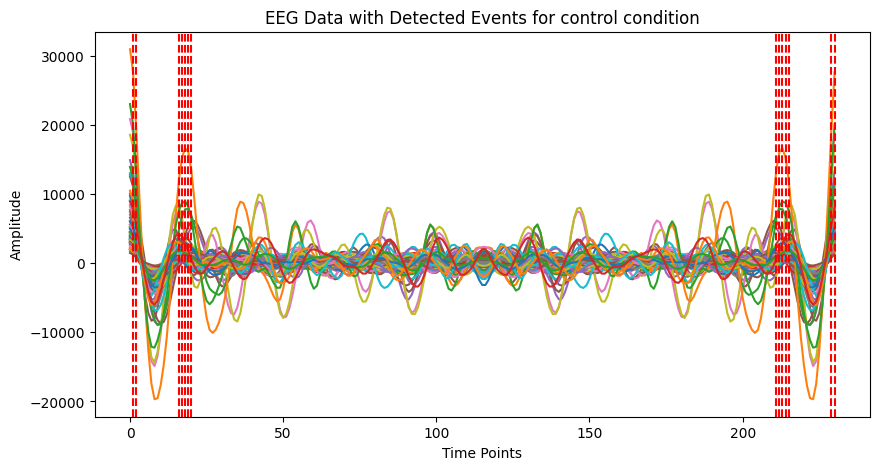

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic EEG data
np.random.seed(42)
num_patients, num_trials, num_channels, num_time_points = inverse_transformed_control.shape
eeg_data = inverse_transformed_control
# Ensure data is real (should be the case with synthetic data created using np.random.randn)
if not np.isrealobj(eeg_data):
    eeg_data = eeg_data.real
# Flatten the data to consider all points for threshold calculation
flattened_data = eeg_data.flatten()

# Statistical thresholding
mean = np.mean(flattened_data)
std = np.std(flattened_data)
threshold_stat = mean + 3 * std

# Percentile-based thresholding
threshold_percentile = np.percentile(flattened_data, 95)

# Print the thresholds
print(f"Statistical Threshold: {threshold_stat}")
print(f"Percentile-Based Threshold: {threshold_percentile}")

# Detect events based on the chosen threshold
events = []
for patient in range(num_patients):
    for trial in range(num_trials):
        for time_point in range(1, num_time_points):
            if eeg_data[patient, trial, :, time_point].max() > threshold_stat:
                events.append((patient, trial, time_point))

# Plot an example trial with detected events
patient_idx = 0
trial_idx = 0
time = np.arange(num_time_points)

plt.figure(figsize=(10, 5))
for ch in range(num_channels):
    plt.plot(time, eeg_data[patient_idx, trial_idx, ch, :] + ch * 5, label=f'Ch {ch}')

for event in events:
    if event[0] == patient_idx and event[1] == trial_idx:
        plt.axvline(event[2], color='r', linestyle='--')

plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.title('EEG Data with Detected Events for control condition')
plt.show()

#### events for pts condition

Statistical Threshold: 6238.644417352805
Percentile-Based Threshold: 1597.103709049595


Text(0.5, 1.0, 'EEG Data with Detected Events for pts condition')

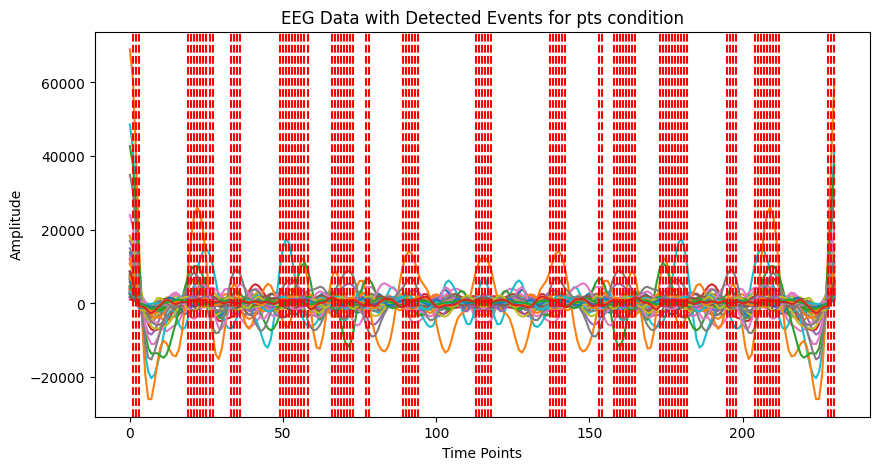

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic EEG data
np.random.seed(42)
num_patients, num_trials, num_channels, num_time_points = inverse_transformed_pts.shape
eeg_data = inverse_transformed_pts
# Ensure data is real (should be the case with synthetic data created using np.random.randn)
if not np.isrealobj(eeg_data):
    eeg_data = eeg_data.real
# Flatten the data to consider all points for threshold calculation
flattened_data = eeg_data.flatten()

# Statistical thresholding
mean = np.mean(flattened_data)
std = np.std(flattened_data)
threshold_stat = mean + 3 * std

# Percentile-based thresholding
threshold_percentile = np.percentile(flattened_data, 95)

# Print the thresholds
print(f"Statistical Threshold: {threshold_stat}")
print(f"Percentile-Based Threshold: {threshold_percentile}")

# Detect events based on the chosen threshold
events = []
for patient in range(num_patients):
    for trial in range(num_trials):
        for time_point in range(1, num_time_points):
            if eeg_data[patient, trial, :, time_point].max() > threshold_stat:
                events.append((patient, trial, time_point))

# Plot an example trial with detected events
patient_idx = 0
trial_idx = 0
time = np.arange(num_time_points)

plt.figure(figsize=(10, 5))
for ch in range(num_channels):
    plt.plot(time, eeg_data[patient_idx, trial_idx, ch, :] + ch * 5, label=f'Ch {ch}')

for event in events:
    if event[0] == patient_idx and event[1] == trial_idx:
        plt.axvline(event[2], color='r', linestyle='--')

plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.title('EEG Data with Detected Events for pts condition')

### Pipeline 1: Fourier transform with bandpass filter, PCA on channels, PCA on time points

In [15]:
# Apply filter
freq_domain_train = apply_fourier_transform_with_bandpass(X_train_scaled, fs=256)
print(freq_domain_train.shape)
freq_domain_test = apply_fourier_transform_with_bandpass(X_test_scaled, fs=256)
print(freq_domain_test.shape)
freq_domain_val = apply_fourier_transform_with_bandpass(X_val_scaled, fs=256)
print(freq_domain_val.shape)

(16, 231, 64, 231)
(2, 231, 64, 231)
(2, 231, 64, 231)


In [16]:
# Call the function to apply PCA to extracted features of train data
preprocessed_train, _= apply_pca_to_X(freq_domain_train, n_components=10)#we can tune n_components, however we tried with 10 and 50 and both gave us the same accuracy on classification task
print(preprocessed_train.shape)
# Call the function to apply PCA to extracted features of test data
preprocessed_test, _ = apply_pca_to_X(freq_domain_test, n_components=10) 
print(preprocessed_test.shape)
preprocessed_val, _ = apply_pca_to_X(freq_domain_val, n_components=10)
print(preprocessed_val.shape)

(16, 231, 10, 231)
(2, 231, 10, 231)
(2, 231, 10, 231)


In [17]:
# Call the function to apply PCA to extracted features of train data
pca_transformed_train, _= apply_pca_to_X(preprocessed_train, n_components=13, pca_dim='time_points')#we can tune n_components, however we tried with 10 and 50 and both gave us the same accuracy on classification task
print(pca_transformed_train.shape)
# Call the function to apply PCA to extracted features of test data
pca_transformed_test, _ = apply_pca_to_X(preprocessed_test, n_components=13, pca_dim='time_points') 
print(pca_transformed_test.shape)
pca_transformed_val, _ = apply_pca_to_X(preprocessed_val, n_components=13, pca_dim='time_points')
print(pca_transformed_val.shape)

(16, 231, 10, 13)
(2, 231, 10, 13)
(2, 231, 10, 13)


### Pipeline 2: Morlet transform, PCA on channels, PCA on time points

In [18]:
# Call the function to apply Morlet wavelet transform

wavelet_freq = 40 # Example frequency of the Morlet wavelet (adjust as needed)
morlet_coeffs_train = apply_morlet_transform(X_train_scaled, wavelet_freq)
morlet_coeffs_test = apply_morlet_transform(X_test_scaled, wavelet_freq)
morlet_coeffs_val = apply_morlet_transform(X_val_scaled, wavelet_freq)
wavelet_features_train=morlet_coeffs_train
wavelet_features_test=morlet_coeffs_test
wavelet_features_val=morlet_coeffs_val
print(wavelet_features_train.shape)

(16, 231, 64, 231)


In [19]:
# Call the function to apply PCA to extracted features of train data
preprocessed_train1, _ = apply_pca_to_X(wavelet_features_train, n_components=10)#we can tune n_components, however we tried with 10 and 50 and both gave us the same accuracy on classification task
print(preprocessed_train1.shape)
# Call the function to apply PCA to extracted features of test data
preprocessed_test1, _ = apply_pca_to_X(wavelet_features_test, n_components=10)
print(preprocessed_test1.shape)
preprocessed_val1, _ = apply_pca_to_X(wavelet_features_val, n_components=10)
print(preprocessed_val1.shape)

(16, 231, 10, 231)
(2, 231, 10, 231)
(2, 231, 10, 231)


In [20]:
# Call the function to apply PCA to extracted features of train data
pca_transformed_train1, _= apply_pca_to_X(preprocessed_train1, n_components=13, pca_dim="time_points")#we can tune n_components, however we tried with 10 and 50 and both gave us the same accuracy on classification task
print(pca_transformed_train1.shape)
# Call the function to apply PCA to extracted features of test data
pca_transformed_test1, _ = apply_pca_to_X(preprocessed_test1, n_components=13, pca_dim="time_points")
print(pca_transformed_test1.shape)
pca_transformed_val1, _ = apply_pca_to_X(preprocessed_val1, n_components=13, pca_dim="time_points")
print(pca_transformed_val1.shape)

(16, 231, 10, 13)
(2, 231, 10, 13)
(2, 231, 10, 13)


In [21]:
# Reshape X_train to combine participants and trials into a single dimension
X_train_reshaped = pca_transformed_train.reshape(-1, pca_transformed_train.shape[2] * pca_transformed_train.shape[3])

# Reshape X_test and X_val similarly
X_test_reshaped = pca_transformed_test.reshape(-1, pca_transformed_test.shape[2] * pca_transformed_test.shape[3])
X_val_reshaped = pca_transformed_val.reshape(-1, pca_transformed_val.shape[2] * pca_transformed_val.shape[3])

# Reshape y data to combine participants and trials into a single dimension
# Repeat each label for each trial
y_train_reshaped = np.repeat(y_train, pca_transformed_train.shape[1])
y_test_reshaped = np.repeat(y_test, pca_transformed_test.shape[1])
y_val_reshaped = np.repeat(y_val, pca_transformed_val.shape[1])

# Reshape X_train to combine participants and trials into a single dimension
X_train_reshaped1 = pca_transformed_train1.reshape(-1, pca_transformed_train1.shape[2] * pca_transformed_train1.shape[3])

# Reshape X_test and X_val similarly
X_test_reshaped1 = pca_transformed_test1.reshape(-1, pca_transformed_test1.shape[2] * pca_transformed_test1.shape[3])
X_val_reshaped1 = pca_transformed_val1.reshape(-1, pca_transformed_val1.shape[2] * pca_transformed_val1.shape[3])

# Reshape y data to combine participants and trials into a single dimension
# Repeat each label for each trial
y_train_reshaped1 = np.repeat(y_train, pca_transformed_train1.shape[1])
y_test_reshaped1 = np.repeat(y_test, pca_transformed_test1.shape[1])
y_val_reshaped1 = np.repeat(y_val, pca_transformed_val1.shape[1])

# 3. Classification w/ Hyperparameter Tuning

### Checks before model running

In [22]:
# Check the class distribution in the training and validation sets
print("Training class distribution:", np.bincount(y_train_reshaped.astype(int)))
print("Validation class distribution:", np.bincount(y_val_reshaped.astype(int)))

Training class distribution: [1848 1848]
Validation class distribution: [231 231]


Conclusion: The class distribution is balanced in both the training and validation datasets. Each class (0 and 1) has an equal number of samples

In [23]:
# Ensure the features are properly scaled
print("Training data feature statistics (mean, std):")
print("Mean:", np.mean(X_train_reshaped))
print("Std Dev:", np.std(X_train_reshaped))

print("Validation data feature statistics (mean, std):")
print("Mean:", np.mean(X_val_reshaped))
print("Std Dev:", np.std(X_val_reshaped))

Training data feature statistics (mean, std):
Mean: 1.1629902280413068e-14
Std Dev: 5513.308063448239
Validation data feature statistics (mean, std):
Mean: -3.101307274776818e-14
Std Dev: 9209.79236048559


Conclusion: The mean values are extremely close to zero, which is typical for standardized data.
The standard deviations are quite large, indicating significant variation in the features.
These values seem reasonable for standardized data, suggesting that the feature scaling was performed correctly

### Pipeline 1: Fourier transform with bandpass filter, PCA on channels, PCA on time points

#### Support Vector Machine

In [24]:
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# Define the SVM model
svm_model = SVC()

# Define the pipeline with feature scaling and SVM
svm_pipeline = Pipeline([
    ('svm', svm_model)
])

# Define the range of hyperparameters to search over
param_dist_svm = {
    'svm__kernel': ['linear', 'poly', 'rbf'],   # SVM kernel
    'svm__C': [0.1, 1.5, 10]                      # Regularization parameter C
}

# Perform HalvingRandomSearchCV for SVM
halving_search_svm = HalvingRandomSearchCV(svm_pipeline, param_dist_svm, n_jobs=-1, factor=3, random_state=42)
print('Performing halving random search for SVM...')
halving_search_svm.fit(X_train_reshaped, y_train_reshaped)
best_params_svm = halving_search_svm.best_params_
print("Best Hyperparameters for SVM:", best_params_svm)
best_model_svm = halving_search_svm.best_estimator_

# Evaluate the best SVM model on the validation set
val_accuracy_svm = best_model_svm.score(X_val_reshaped, y_val_reshaped)
print("Validation Accuracy with Best SVM Model:", val_accuracy_svm)

Performing halving random search for SVM...


/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=184. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters for SVM: {'svm__kernel': 'rbf', 'svm__C': 10}
Validation Accuracy with Best SVM Model: 0.40476190476190477


#### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Define the PCA transformation (you can adjust n_components based on your data)
pca = PCA(n_components=0.95)  # Retain 95% of variance

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the pipeline with PCA and Random Forest
rf_pipeline = Pipeline([
    ('pca', pca),  # Add PCA to the pipeline
    ('rf', rf_model)
])

# Define the range of hyperparameters to search over
param_dist_rf = {
    'rf__n_estimators': [50, 100, 200],            # Number of trees in the forest
    'rf__max_depth': [None, 10, 20, 30],           # Maximum depth of the trees
    'rf__min_samples_split': randint(2, 10),       # Minimum number of samples required to split a node
    'rf__min_samples_leaf': randint(1, 10),        # Minimum number of samples required at each leaf node
    'rf__max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider when looking for the best split
}

# Perform HalvingRandomSearchCV for Random Forest
halving_search_rf = HalvingRandomSearchCV(rf_pipeline, param_dist_rf, n_jobs=-1, factor=3, random_state=42)
print('Performing halving random search for Random Forest...')
halving_search_rf.fit(X_train_reshaped, y_train_reshaped)
best_params_rf = halving_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)
best_model_rf = halving_search_rf.best_estimator_

# Evaluate the best Random Forest model on the validation set
val_accuracy_rf = best_model_rf.score(X_val_reshaped, y_val_reshaped)
print("Validation Accuracy with Best Random Forest Model:", val_accuracy_rf)

Performing halving random search for Random Forest...


/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
355 fits failed out of a total of 920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
223 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn

Best Hyperparameters for Random Forest: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Validation Accuracy with Best Random Forest Model: 0.6753246753246753


In [26]:
# Get feature importances
feature_importances = best_model_rf.named_steps['rf'].feature_importances_

# Print feature importances (if needed)
print("Feature Importances:", feature_importances)

Feature Importances: [0.06688282 0.02367411 0.03213389 0.02158566 0.01607427 0.01488441
 0.01658682 0.01269459 0.01549742 0.01457403 0.0122594  0.01374612
 0.01241044 0.01409013 0.01517929 0.01238703 0.01159537 0.01385424
 0.01610901 0.0131369  0.01112127 0.01411683 0.01333538 0.01651404
 0.01254399 0.01190204 0.01228247 0.01334439 0.01321875 0.01315426
 0.01321667 0.01364208 0.01418704 0.01260459 0.01161893 0.01738245
 0.01347908 0.01481811 0.01197288 0.01279568 0.01516609 0.0140262
 0.01429468 0.012772   0.01999454 0.01359209 0.01386266 0.01450758
 0.01653581 0.01562838 0.02111931 0.01393033 0.01265308 0.01440684
 0.01298085 0.01431484 0.01595815 0.01367765 0.01741971 0.01453821
 0.01225843 0.01120837 0.01248449 0.01173604 0.01432675]


### Pipeline 2: Morlet transform, PCA on channels, PCA on time points

#### Support Vector Machine

In [27]:
# Perform HalvingRandomSearchCV for SVM
halving_search_svm1 = HalvingRandomSearchCV(svm_pipeline, param_dist_svm, n_jobs=-1, factor=3, random_state=42)
print('Performing halving random search for SVM...')
halving_search_svm1.fit(X_train_reshaped1, y_train_reshaped1)
best_params_svm1 = halving_search_svm1.best_params_
print("Best Hyperparameters for SVM:", best_params_svm1)
best_model_svm1 = halving_search_svm1.best_estimator_

# Evaluate the best SVM model on the validation set
val_accuracy_svm1 = best_model_svm1.score(X_val_reshaped1, y_val_reshaped1)
print("Validation Accuracy with Best SVM Model:", val_accuracy_svm1)

Performing halving random search for SVM...


/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=184. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters for SVM: {'svm__kernel': 'rbf', 'svm__C': 1.5}
Validation Accuracy with Best SVM Model: 0.5108225108225108


#### Random Forest

In [28]:
# Perform HalvingRandomSearchCV for Random Forest
halving_search_rf1 = HalvingRandomSearchCV(rf_pipeline, param_dist_rf, n_jobs=-1, factor=3, random_state=42)
print('Performing halving random search for Random Forest...')
halving_search_rf1.fit(X_train_reshaped1, y_train_reshaped1)
best_params_rf1 = halving_search_rf1.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf1)
best_model_rf1 = halving_search_rf1.best_estimator_

# Evaluate the best Random Forest model on the validation set
val_accuracy_rf1 = best_model_rf1.score(X_val_reshaped1, y_val_reshaped1)
print("Validation Accuracy with Best Random Forest Model:", val_accuracy_rf1)

Performing halving random search for Random Forest...


/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
355 fits failed out of a total of 920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
154 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn

Best Hyperparameters for Random Forest: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 8, 'rf__n_estimators': 200}
Validation Accuracy with Best Random Forest Model: 0.5281385281385281


In [29]:
# Get feature importances
feature_importances1 = best_model_rf1.named_steps['rf'].feature_importances_

# Print feature importances (if needed)
print("Feature Importances:", feature_importances1)

Feature Importances: [0.12017954 0.0220067  0.01272975 0.01736974 0.0158341  0.01088295
 0.01867587 0.01396215 0.0118949  0.01075874 0.01052573 0.01399746
 0.01278557 0.01261434 0.01224253 0.01123174 0.01365262 0.00955323
 0.01091781 0.01083384 0.00963239 0.0098306  0.00981758 0.01183363
 0.01191757 0.01251426 0.01162395 0.01248482 0.01141311 0.01118539
 0.01320287 0.01198963 0.01183401 0.01196604 0.01206429 0.01421506
 0.01536094 0.01060961 0.0112872  0.01414858 0.01071143 0.01197323
 0.01181831 0.0163849  0.00968312 0.01098683 0.01108276 0.0116164
 0.01323741 0.01135189 0.01216722 0.01250107 0.01881079 0.01059272
 0.01188283 0.01293462 0.01255406 0.0109905  0.01170009 0.01141254
 0.01140275 0.01444274 0.01104753 0.01371481 0.01330483 0.00925231
 0.01679677 0.01206375 0.00885644 0.01091777 0.01174488 0.0104819 ]


Conclusion: Best model/pipeline combination is pipeline 1 with random forest

# 4. Assess performance

In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score

# Define a function to compute metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred, average='binary'),
        'Specificity': recall_score(y_true, y_pred, pos_label=0, average='binary'),
        'F1 Score': f1_score(y_true, y_pred, average='binary'),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred)
    }
    return metrics

# Predict on the train, test, and validation sets
y_train_pred_svm = best_model_svm.predict(X_train_reshaped)
y_test_pred_svm = best_model_svm.predict(X_test_reshaped)
y_val_pred_svm = best_model_svm.predict(X_val_reshaped)
y_train_pred_svm1 = best_model_svm1.predict(X_train_reshaped1)
y_test_pred_svm1 = best_model_svm1.predict(X_test_reshaped1)
y_val_pred_svm1 = best_model_svm1.predict(X_val_reshaped1)
y_train_pred_rf = best_model_rf.predict(X_train_reshaped)
y_test_pred_rf = best_model_rf.predict(X_test_reshaped)
y_val_pred_rf = best_model_rf.predict(X_val_reshaped)
y_train_pred_rf1 = best_model_rf1.predict(X_train_reshaped1)
y_test_pred_rf1 = best_model_rf.predict(X_test_reshaped1)
y_val_pred_rf1 = best_model_rf.predict(X_val_reshaped1)

# Compute metrics
svm_metrics_train = compute_metrics(y_train_reshaped, y_train_pred_svm)
svm_metrics_test = compute_metrics(y_test_reshaped, y_test_pred_svm)
svm_metrics_val = compute_metrics(y_val_reshaped, y_val_pred_svm)
svm_metrics_train1 = compute_metrics(y_train_reshaped1, y_train_pred_svm1)
svm_metrics_test1 = compute_metrics(y_test_reshaped1, y_test_pred_svm1)
svm_metrics_val1 = compute_metrics(y_val_reshaped1, y_val_pred_svm1)
rf_metrics_train = compute_metrics(y_train_reshaped, y_train_pred_rf)
rf_metrics_test = compute_metrics(y_test_reshaped, y_test_pred_rf)
rf_metrics_val = compute_metrics(y_val_reshaped, y_val_pred_rf)
rf_metrics_train1 = compute_metrics(y_train_reshaped1, y_train_pred_rf1)
rf_metrics_test1 = compute_metrics(y_test_reshaped1, y_test_pred_rf1)
rf_metrics_val1 = compute_metrics(y_val_reshaped1, y_val_pred_rf1)

# Assuming we have results for multiple participants, we can compute mean and standard deviation
svm_results_train = [svm_metrics_train]  # List of dictionaries for train results across participants
svm_results_test = [svm_metrics_test]    # List of dictionaries for test results across participants
svm_results_val = [svm_metrics_val]      # List of dictionaries for validation results across participants
svm_results_train1 = [svm_metrics_train1]  # List of dictionaries for train results across participants
svm_results_test1 = [svm_metrics_test1]    # List of dictionaries for test results across participants
svm_results_val1 = [svm_metrics_val1]      # List of dictionaries for validation results across participants
rf_results_train = [rf_metrics_train]  # List of dictionaries for train results across participants
rf_results_test = [rf_metrics_test]    # List of dictionaries for test results across participants
rf_results_val = [rf_metrics_val]      # List of dictionaries for validation results across participants
rf_results_train1 = [rf_metrics_train1]  # List of dictionaries for train results across participants
rf_results_test1 = [rf_metrics_test1]    # List of dictionaries for test results across participants
rf_results_val1 = [rf_metrics_val1]      # List of dictionaries for validation results across participants

# Compute mean and std for each metric across participants
def summarize_metrics(results):
    summary = {}
    for key in results[0].keys():
        values = [result[key] for result in results]
        summary[key] = {
            'mean': np.mean(values),
            'std': np.std(values)
        }
    return summary

svm_train_summary = summarize_metrics(svm_results_train)
svm_test_summary = summarize_metrics(svm_results_test)
svm_val_summary = summarize_metrics(svm_results_val)
svm_train_summary1 = summarize_metrics(svm_results_train1)
svm_test_summary1 = summarize_metrics(svm_results_test1)
svm_val_summary1 = summarize_metrics(svm_results_val1)
rf_train_summary = summarize_metrics(rf_results_train)
rf_test_summary = summarize_metrics(rf_results_test)
rf_val_summary = summarize_metrics(rf_results_val)
rf_train_summary1 = summarize_metrics(rf_results_train1)
rf_test_summary1 = summarize_metrics(rf_results_test1)
rf_val_summary1 = summarize_metrics(rf_results_val1)

# Print summary
print("SVM Training Metrics: ", svm_train_summary)
print("SVM Testing Metrics: ", svm_test_summary)
print("SVM Validation Metrics: ", svm_val_summary)
print("SVM Training 1 Metrics: ", svm_train_summary1)
print("SVM Testing 1 Metrics: ", svm_test_summary1)
print("SVM Validation 1 Metrics: ", svm_val_summary1)
print("RF Training Metrics: ", rf_train_summary)
print("RF Testing Metrics: ", rf_test_summary)
print("RF Validation Metrics: ", rf_val_summary)
print("RF Training 1 Metrics: ", rf_train_summary1)
print("RF Testing 1 Metrics: ", rf_test_summary1)
print("RF Validation 1 Metrics: ", rf_val_summary1)

SVM Training Metrics:  {'Accuracy': {'mean': 0.775974025974026, 'std': 0.0}, 'Recall': {'mean': 0.5687229437229437, 'std': 0.0}, 'Specificity': {'mean': 0.9832251082251082, 'std': 0.0}, 'F1 Score': {'mean': 0.7174061433447099, 'std': 0.0}, 'Balanced Accuracy': {'mean': 0.775974025974026, 'std': 0.0}}
SVM Testing Metrics:  {'Accuracy': {'mean': 0.5627705627705628, 'std': 0.0}, 'Recall': {'mean': 1.0, 'std': 0.0}, 'Specificity': {'mean': 0.12554112554112554, 'std': 0.0}, 'F1 Score': {'mean': 0.6957831325301205, 'std': 0.0}, 'Balanced Accuracy': {'mean': 0.5627705627705628, 'std': 0.0}}
SVM Validation Metrics:  {'Accuracy': {'mean': 0.40476190476190477, 'std': 0.0}, 'Recall': {'mean': 0.670995670995671, 'std': 0.0}, 'Specificity': {'mean': 0.13852813852813853, 'std': 0.0}, 'F1 Score': {'mean': 0.5299145299145299, 'std': 0.0}, 'Balanced Accuracy': {'mean': 0.40476190476190477, 'std': 0.0}}
SVM Training 1 Metrics:  {'Accuracy': {'mean': 0.8068181818181818, 'std': 0.0}, 'Recall': {'mean': 0.

In [31]:
pd.DataFrame(svm_test_summary1)

,Accuracy,Recall,Specificity,F1 Score,Balanced Accuracy
mean,0.580087,1.0,0.160173,0.704268,0.580087
std,0.000000,0.0,0.000000,0.000000,0.000000


Conclusion: ______

### Empirical Chance Level

p-value for SVM: 0.006836007551523667
p-value for SVM1: 0.0005410574344892714
SVM Accuracy: 0.40476190476190477, p-value: 0.006836007551523667, Significant: True
SVM1 Accuracy: 0.5108225108225108, p-value: 0.0005410574344892714, Significant: True


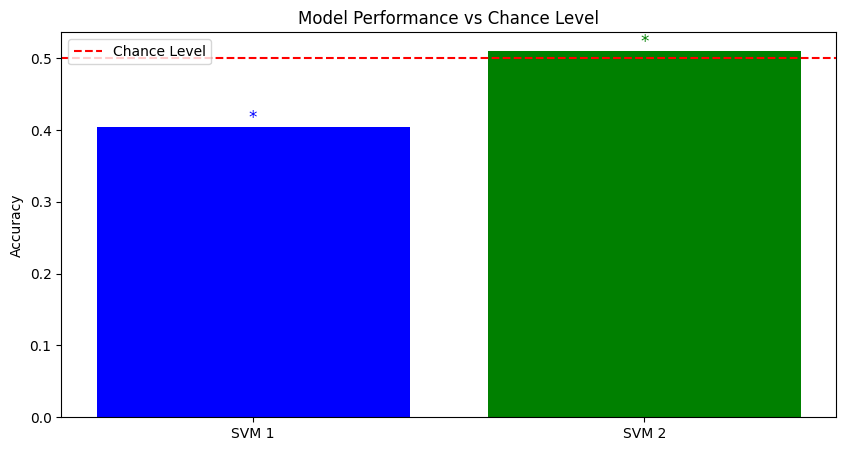

In [32]:
from scipy.stats import ttest_1samp

# Calculate accuracy for each prediction
accuracies_svm = (y_test_pred_svm == y_test_reshaped).astype(int)
accuracies_svm1 = (y_test_pred_svm1 == y_test_reshaped1).astype(int)

# Calculate accuracies
accuracy_svm = accuracy_score(y_val_reshaped, y_val_pred_svm)
accuracy_svm1 = accuracy_score(y_val_reshaped1, y_val_pred_svm1)

# Define the empirical chance level
empirical_chance = 1 / len(np.unique(y_train_reshaped))  # Assuming empirical chance level is the inverse of the number of classes
empirical_chance1 = 1 / len(np.unique(y_train_reshaped1))  # Assuming empirical chance level is the inverse of the number of classes

# Perform hypothesis tests
t_stat_svm, p_value_svm = ttest_1samp(accuracies_svm, empirical_chance)
t_stat_svm1, p_value_svm1 = ttest_1samp(accuracies_svm1, empirical_chance1)

print("p-value for SVM:", p_value_svm)
print("p-value for SVM1:", p_value_svm1)

# Identify significance
alpha = 0.05  # Significance level
significant_svm = p_value_svm <= alpha
significant_svm1 = p_value_svm1 <= alpha

# Print the results
print(f"SVM Accuracy: {accuracy_svm}, p-value: {p_value_svm}, Significant: {significant_svm}")
print(f"SVM1 Accuracy: {accuracy_svm1}, p-value: {p_value_svm1}, Significant: {significant_svm1}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.bar(['SVM 1', 'SVM 2'], [accuracy_svm, accuracy_svm1], color=['blue', 'green'])
plt.axhline(y=empirical_chance, color='red', linestyle='--', label='Chance Level')
plt.title('Model Performance vs Chance Level')
plt.ylabel('Accuracy')
plt.legend()

# Highlight significant results
if significant_svm:
    plt.text(0, accuracy_svm, '*', fontsize=12, ha='center', va='bottom', color='blue')
if significant_svm1:
    plt.text(1, accuracy_svm1, '*', fontsize=12, ha='center', va='bottom', color='green')

plt.show()

p-value for SVM: 2.4334862345788874e-05
p-value for RF: 1.3232836741638428e-09
SVM Accuracy: 0.5974025974025974, p-value: 2.4334862345788874e-05, Significant: True
RF Accuracy: 0.70995670995671, p-value: 1.3232836741638428e-09, Significant: True


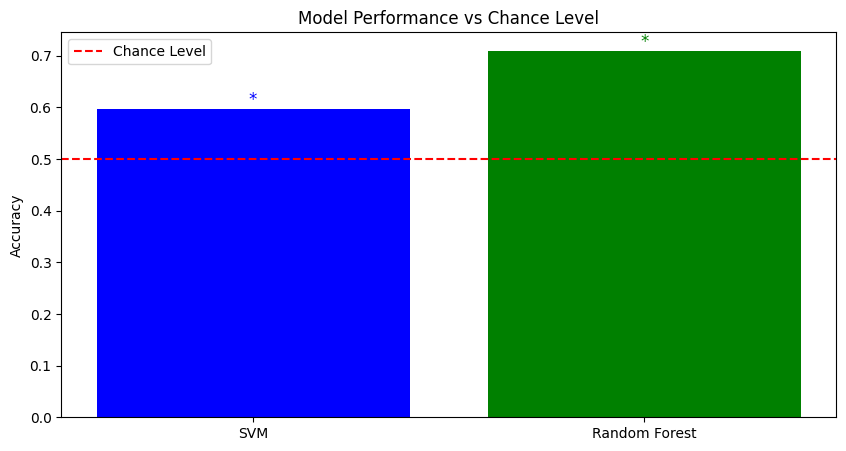

In [111]:
from scipy.stats import ttest_1samp

# Calculate accuracy for each prediction
accuracies_svm = (y_test_pred_svm == y_test_reshaped1).astype(int)
accuracies_rf = (y_test_pred_rf == y_test_reshaped1).astype(int)

# Calculate accuracies
accuracy_svm = accuracy_score(y_val_reshaped1, y_val_pred_svm)
accuracy_rf = accuracy_score(y_val_reshaped1, y_val_pred_rf)

# Define the empirical chance level
empirical_chance = 1 / len(np.unique(y_train_reshaped1))  # Assuming empirical chance level is the inverse of the number of classes

# Perform hypothesis tests
t_stat_svm, p_value_svm = ttest_1samp(accuracies_svm, empirical_chance)
t_stat_rf, p_value_rf = ttest_1samp(accuracies_rf, empirical_chance)

print("p-value for SVM:", p_value_svm)
print("p-value for RF:", p_value_rf)

# Identify significance
alpha = 0.05  # Significance level
significant_svm = p_value_svm <= alpha
significant_rf = p_value_rf <= alpha

# Print the results
print(f"SVM Accuracy: {accuracy_svm}, p-value: {p_value_svm}, Significant: {significant_svm}")
print(f"RF Accuracy: {accuracy_rf}, p-value: {p_value_rf}, Significant: {significant_rf}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.bar(['SVM', 'Random Forest'], [accuracy_svm, accuracy_rf], color=['blue', 'green'])
plt.axhline(y=empirical_chance, color='red', linestyle='--', label='Chance Level')
plt.title('Model Performance vs Chance Level')
plt.ylabel('Accuracy')
plt.legend()

# Highlight significant results
if significant_svm:
    plt.text(0, accuracy_svm, '*', fontsize=12, ha='center', va='bottom', color='blue')
if significant_rf:
    plt.text(1, accuracy_rf, '*', fontsize=12, ha='center', va='bottom', color='green')

plt.show()

# 6. Rank features

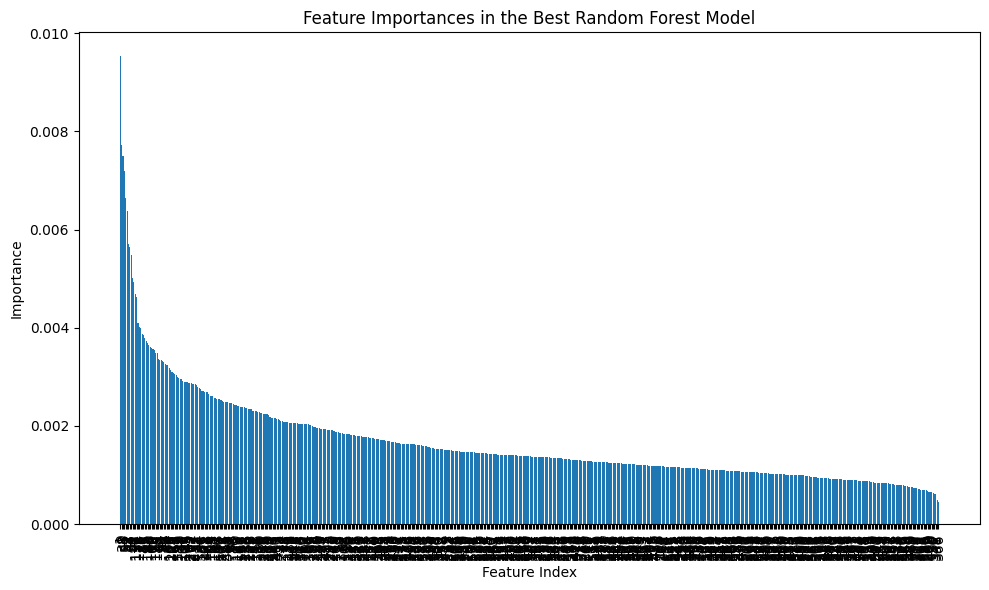

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the best random forest model
feature_importances = best_model_rf.named_steps['rf'].feature_importances_

# Get the indices of the sorted feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in the Best Random Forest Model")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), sorted_indices, rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Rank top 20 features

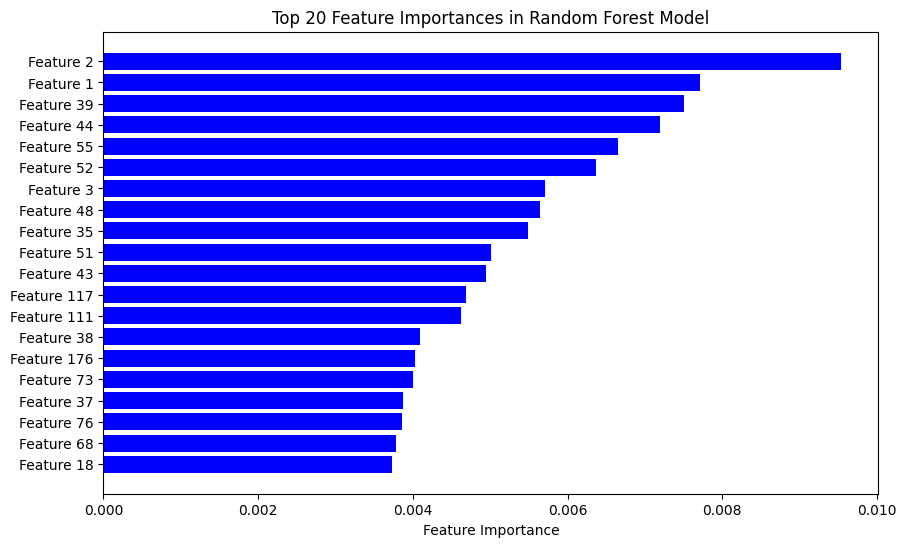

In [113]:
# Extract feature importances from the best random forest model
feature_importances = best_model_rf.named_steps['rf'].feature_importances_

# Get the indices of the top 20 features
top_20_indices = np.argsort(feature_importances)[-20:]

# Get the top 20 feature importances
top_20_importances = feature_importances[top_20_indices]

# Get the names of the top 20 features
top_20_features = [f'Feature {i+1}' for i in top_20_indices]

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features, top_20_importances, color='b', align='center')
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in Random Forest Model')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the Decision Tree model
dt_model = DecisionTreeClassifier()

# Define the pipeline with PCA and Decision Tree
dt_pipeline = Pipeline([
    ('decision_tree', dt_model)
])

# Define hyperparameters to tune
param_grid = {
    'decision_tree__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'decision_tree__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'decision_tree__min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_reshaped, y_train_reshaped)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_val_pred_dt_tuned = best_dt_model.predict(X_val_reshaped)

# Evaluate the best model
val_accuracy_dt_tuned = best_dt_model.score(X_val_reshaped, y_val_pred_dt_tuned)
print("Tuned Decision Tree Validation Accuracy:", val_accuracy_dt_tuned)

Best Parameters: {'decision_tree__max_depth': 20, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 2}
Tuned Decision Tree Validation Accuracy: 1.0


In [ ]:
# Specify options for kernel and regularization parameter (C)
kernel = 'linear'  # Options: 'linear', 'poly', 'rbf', 'sigmoid', etc.
C = 10  # Regularization parameter. Higher values lead to stronger regularization.

# Define the SVM model
svm_model1 = SVC()

# Define the pipeline with PCA and SVM
svm_pipeline1 = Pipeline([
    ('svm', svm_model1)
])

# Train the model
svm_pipeline1.fit(X_train_reshaped1, y_train_reshaped1)

# Predict on the test set
y_val_pred_svm1 = svm_pipeline1.predict(X_val_reshaped1)

# Evaluate the model
val_accuracy_svm1 = svm_pipeline1.score(X_val_reshaped1, y_val_reshaped1)
print("SVM Validation Accuracy:", val_accuracy_svm1)

SVM Validation Accuracy: 0.512987012987013


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf_model1 = RandomForestClassifier(n_estimators=100)

# Define the pipeline with PCA and Random Forest
rf_pipeline1 = Pipeline([
    ('rf', rf_model1)
])

# Train the model
rf_pipeline1.fit(X_train_reshaped1, y_train_reshaped1)

# Get feature importances
feature_importances1 = rf_pipeline1.named_steps['rf'].feature_importances_

# Print feature importances (if needed)
print("Feature Importances:", feature_importances1)

# Predict on the test set
y_val_pred_rf1 = rf_pipeline1.predict(X_val_reshaped1)

# Evaluate the model
val_accuracy_rf1 = rf_pipeline1.score(X_val_reshaped1, y_val_reshaped1)
print("Random Forest Validation Accuracy:", val_accuracy_rf1)

Random Forest Validation Accuracy: 0.49783549783549785
